# Traveltime.ipynb

横軸にEuropaの磁気緯度をとって、Alfven波のトラベルタイムをプロットする。

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap  # colormapをカスタマイズする
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import B_JRM33 as BJRM
import B_equator as BEQ
import Leadangle_wave as LeadA
from TScmap import TScmap

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF',
        '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF',
          '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

# matplotlib フォント設定
fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                     'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold',
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

In [3]:
# %% 定数
MOON = 'Europa'
MU0 = 1.26E-6            # 真空中の透磁率
AMU = 1.66E-27           # [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
RE = 1.56E+6             # MOON RADIUS [m]
C = 2.99792E+8           # 光速 [m/s]
OMGJ = 1.75868E-4        # 木星の自転角速度 [rad/s]
r_orbit = 9.38*RJ        # ORBITAL RADIUS (average) [m] (Bagenal+2015)
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
OMGR = 2*np.pi/(Psyn_eu)    # Moon's synodic angular velocity [rad/sec]
u = 100E+3              # 共回転速度 [m s-1]
a_bar = 0.8             # 1-プラズマフローの減速率 (Saur+1998)
R_eff = 4.2*RE/2        # フラックスチューブの半径
Ai = 18                 # イオン原子量 [amu]

In [4]:
rho0 = 1708     # [amu cm-3]
Ti = 195        # [eV]
Hp = 0.64*RJ*math.sqrt(Ti/Ai)   # [m]

In [5]:
# 磁気緯度
Mlat = np.radians(np.linspace(0,30,5))   # [rad]


# 磁力上 footprintまでの距離
r = r_orbit                # [m]
theta = np.pi/2            # 余緯度(Europa公転面) [rad]
S3wlon = 114+90               # S3経度 [deg]
phi = np.radians(360-S3wlon)  # 東向き経度 [rad] Center / Northernmost
x = r*math.sin(theta)*math.cos(phi)
y = r*math.sin(theta)*math.sin(phi)
z = r*math.cos(theta)

# 遠心力赤道からEuropaまでの距離
S0 = LeadA.Awave().tracefield(r, math.radians(S3wlon))     # [m]
print(S0/RJ, '[RJ]')


# Europaからfootprintまでの距離
sf = 0


# 伝搬時間
tau = 0     # [sec]


# 線要素
ds = 70000     # [m]


# 座標格納
R_arr = np.zeros(20000)
z_arr = np.zeros(R_arr.size)
R_arr[0] = math.sqrt(x**2 + y**2)
z_arr[0] = z


# 北向きに磁力線をトレースし距離を計測する
ns = -1     # 北向き -1
for i in range(R_arr.size):
    Bv = BJRM.B().JRM33(r, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    # プラズマ質量密度 rho
    rho = rho0*AMU*(1E+6)*np.exp(-((S0+sf)/Hp)**2)     # [kg m-3]

    # Alfven速度 Va
    Va = B0/math.sqrt(MU0*rho)    # [m/s]

    # 相対論効果の考慮
    if Va/C > 0.07:
        Va = Va/math.sqrt(1+(Va/C)**2)

    if Va/C > 0.30:
        Va = 0.30*C

    # 時間要素
    dt = ds/Va

    # 伝搬時間
    tau += dt   # [sec]

    # 座標更新 (x, y, z)
    x += (ds*Bx/B0)*ns
    y += (ds*By/B0)*ns
    z += (ds*Bz/B0)*ns

    # 座標更新 (r, theta, phi)
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.acos(z/r)
    phi = math.atan2(y, x)

    # 座標更新 (沿磁力線: S0)
    sf += ds*(-ns)

    R_arr[i] = math.sqrt(x**2 + y**2)
    z_arr[i] = z

    if r < RJ:
        print('Break')
        break

print('E2F distance [RJ]: ', sf/RJ)
print('F latitude [deg]: ', 90-np.degrees(theta))
print('Tau [s]: ', tau)


1.233704470430258 [RJ]
Break
E2F distance [RJ]:  10.232893190846529
F latitude [deg]:  55.733507430376015
Tau [s]:  310.1966879482087


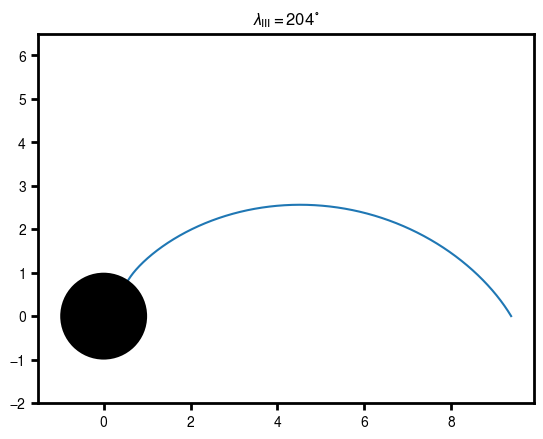

In [6]:
fig, ax = plt.subplots()
ax.axis('equal')
ax.set_title(r'$\lambda_{\rm III} = $'+str(S3wlon)+'˚')
ax.set_ylim((-1,5.5))
ax.plot(R_arr/RJ, z_arr/RJ)
ax.add_patch(plt.Circle((0, 0), RJ/RJ, fc='k', zorder=3))
plt.show()

# 磁気緯度

In [7]:
# 衛星 System III 経度
# S3wlon = np.linspace(21,205,180)   # S3経度 [deg]
S3wlon = np.array([24.2,114,204])   # S3経度 [deg]

# 衛星のトーラス内相対位置
Clat = np.zeros(S3wlon.size)

# S3RH座標系の(x, y, z)座標
phi = np.radians(360-S3wlon)  # 東向き経度 [rad] Center / Northernmost
x0 = r_orbit*np.cos(phi)
y0 = r_orbit*np.sin(phi)
z0 = np.zeros(x0.shape)
rvec0 = np.array([x0, y0, z0])

# S3RH で Z軸 の(右ネジ)まわりに-65.8度回転
phiRH0 = math.radians(-65.8)    # Connerney+2020
rvec0 = np.array([
    rvec0[0, :]*math.cos(phiRH0) - rvec0[1, :]*math.sin(phiRH0),
    rvec0[0, :]*math.sin(phiRH0) + rvec0[1, :]*math.cos(phiRH0),
    rvec0[2, :]
])

# S3RH で X軸 の(右ネジ)まわりに-7度回転 -> 遠心力座標系に
TILT0 = math.radians(6.7)
rvec = np.array([
    rvec0[0, :],
    rvec0[1, :]*math.cos(TILT0) - rvec0[2, :]*math.sin(TILT0),
    rvec0[1, :]*math.sin(TILT0) + rvec0[2, :]*math.cos(TILT0)
])

# 遠心力座標系における緯度を計算する
theta_cent = np.arccos(rvec[2, :]/r_orbit)     # 余緯度 [rad]
Clat = np.degrees(0.5*np.pi-theta_cent)     # 緯度 [deg]

In [8]:
# 磁力上 footprintまでの距離
sf_arr = np.zeros(S3wlon.size)      # [m]

# 伝搬時間
tau_arr = np.zeros(S3wlon.size)

for j in range(S3wlon.size):
    r = r_orbit                # [m]
    theta = np.pi/2            # 余緯度(Europa公転面) [rad]
    phi = np.radians(360-S3wlon[j])  # 東向き経度 [rad] Center / Northernmost
    x = r*math.sin(theta)*math.cos(phi)
    y = r*math.sin(theta)*math.sin(phi)
    z = r*math.cos(theta)

    # 遠心力赤道からEuropaまでの距離
    S0 = LeadA.Awave().tracefield(r, math.radians(S3wlon[j]))     # [m]


    # Europaからfootprintまでの距離
    sf = 0


    # 伝搬時間
    tau = 0     # [sec]


    # 線要素
    ds = 70000     # [m]


    # 座標格納
    R_arr = np.zeros(20000)
    z_arr = np.zeros(R_arr.size)
    R_arr[0] = math.sqrt(x**2 + y**2)
    z_arr[0] = z


    # 北向きに磁力線をトレースし距離を計測する
    ns = -1     # 北向き -1
    for i in range(R_arr.size):
        Bv = BJRM.B().JRM33(r, theta, phi)*1E-9        # [T]
        Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
            + Bv[1]*math.cos(theta)*math.cos(phi) \
            - Bv[2]*math.sin(phi)
        By = Bv[0]*math.sin(theta)*math.sin(phi) \
            + Bv[1]*math.cos(theta)*math.sin(phi) \
            + Bv[2]*math.cos(phi)
        Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

        Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
        Bx += Bcs[0]
        By += Bcs[1]
        Bz += Bcs[2]

        B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

        # プラズマ質量密度 rho
        rho = rho0*AMU*(1E+6)*np.exp(-((S0+sf)/Hp)**2)     # [kg m-3]

        # Alfven速度 Va
        Va = B0/math.sqrt(MU0*rho)    # [m/s]

        # 相対論効果の考慮
        if Va/C > 0.07:
            Va = Va/math.sqrt(1+(Va/C)**2)

        if Va/C > 0.30:
            Va = 0.30*C

        # 時間要素
        dt = ds/Va

        # 伝搬時間
        tau += dt   # [sec]

        # 座標更新 (x, y, z)
        x += (ds*Bx/B0)*ns
        y += (ds*By/B0)*ns
        z += (ds*Bz/B0)*ns

        # 座標更新 (r, theta, phi)
        r = math.sqrt(x**2 + y**2 + z**2)
        theta = math.acos(z/r)
        phi = math.atan2(y, x)

        # 座標更新 (沿磁力線: S0)
        sf += ds*(-ns)

        R_arr[i] = math.sqrt(x**2 + y**2)
        z_arr[i] = z

        if r < RJ:
            # print('Break')
            break

    tau_arr[j] = tau
    
    sf_arr[j] = sf

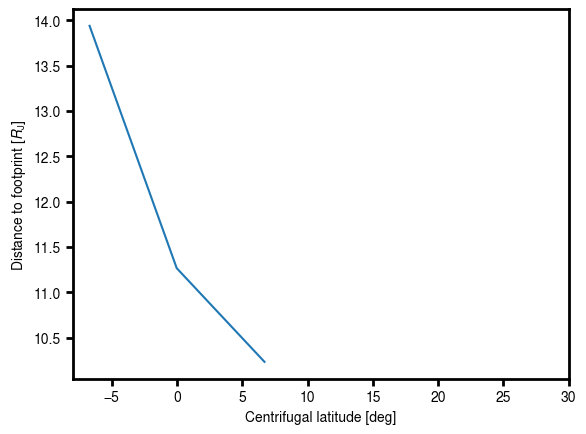

In [9]:
# プロット
fig, ax = plt.subplots()
ax.set_xlabel('Centrifugal latitude [deg]')
ax.set_ylabel(r'Distance to footprint [$R_{\rm J}$]')
ax.set_xlim(-8,30)
ax.plot(Clat, sf_arr/RJ)
plt.show()

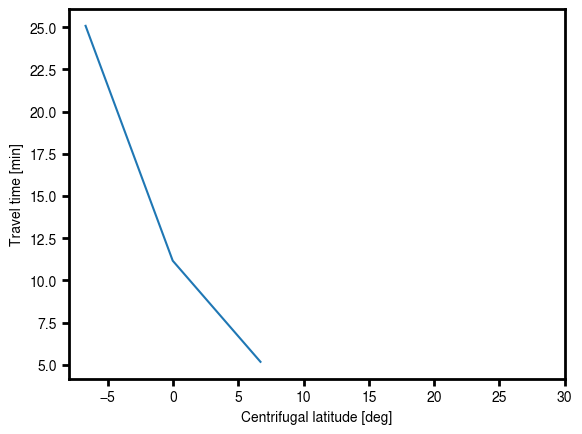

In [10]:
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
OMGR = 2*np.pi/(Psyn_eu)    # Moon's synodic angular velocity [rad/sec]

# プロット
fig, ax = plt.subplots()
ax.set_xlabel('Centrifugal latitude [deg]')
ax.set_ylabel(r'Travel time [min]')
ax.set_xlim(-8,30)
ax.plot(Clat, tau_arr/60)
plt.show()

In [11]:
idx = np.argmax(Clat)
print(S3wlon[idx])

idx = np.argmin(sf_arr)
print(S3wlon[idx])

204.0
204.0


# S3 = 114˚

In [12]:
# 磁力上 footprintまでの距離
r = r_orbit                # [m]
theta = np.radians(100)            # 余緯度(Europa公転面) [rad]
S3wlon = 114               # S3経度 [deg]
phi = np.radians(360-S3wlon)  # 東向き経度 [rad] Center / Northernmost
x = r*math.sin(theta)*math.cos(phi)
y = r*math.sin(theta)*math.sin(phi)
z = r*math.cos(theta)

# 遠心力赤道からEuropaまでの距離
S0 = LeadA.Awave().tracefield(r, math.radians(S3wlon))     # [m]
print(S0/RJ, '[RJ]')
S0 = 0


# Europaからfootprintまでの距離
sf = 0


# 線要素
ds = 50000     # [m]


# 座標格納
R_arr = np.zeros(20000)         # [m]
z_arr = np.zeros(R_arr.size)    # [m]
theta_arr = np.zeros(R_arr.size)    # [rad]
R_arr[0] = math.sqrt(x**2 + y**2)
z_arr[0] = z
theta_arr[0] = theta


# 伝搬時間
tau = 0     # [sec]


# 質量密度
rho_arr = np.zeros(R_arr.size)


# Alfven速度
Va_arr = np.zeros(R_arr.size)


# 北向きに磁力線をトレースし距離を計測する
ns = -1     # 北向き -1
for i in range(R_arr.size):
    Bv = BJRM.B().JRM33(r, theta, phi)*1E-9        # [T]
    Bx = Bv[0]*math.sin(theta)*math.cos(phi) \
        + Bv[1]*math.cos(theta)*math.cos(phi) \
        - Bv[2]*math.sin(phi)
    By = Bv[0]*math.sin(theta)*math.sin(phi) \
        + Bv[1]*math.cos(theta)*math.sin(phi) \
        + Bv[2]*math.cos(phi)
    Bz = Bv[0]*math.cos(theta) - Bv[1]*math.sin(theta)

    Bcs = BJRM.B().BCS(x, y, z, phi)*1E-9  # [T]
    Bx += Bcs[0]
    By += Bcs[1]
    Bz += Bcs[2]

    B0 = math.sqrt(Bx**2+By**2+Bz**2)      # [T]

    # プラズマ質量密度 rho
    rho = rho0*AMU*(1E+6)*np.exp(-((S0-z)/Hp)**2)     # [kg m-3]
    rho_arr[i] = rho/(AMU*(1E+6))                      # [amu cm-3]

    # Alfven速度 Va
    Va = B0/math.sqrt(MU0*rho)    # [m/s]

    # 相対論効果の考慮
    if Va/C > 0.07:
        Va = Va/math.sqrt(1+(Va/C)**2)

    if Va/C > 0.5:
        Va = 0.5*C

    Va_arr[i] = Va

    # 時間要素
    dt = ds/Va

    # 伝搬時間
    tau += dt   # [sec]

    # 座標更新 (x, y, z)
    x += (ds*Bx/B0)*ns
    y += (ds*By/B0)*ns
    z += (ds*Bz/B0)*ns

    # 座標更新 (r, theta, phi)
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.acos(z/r)
    phi = math.atan2(y, x)
    theta_arr[i] = theta

    # 座標更新 (沿磁力線: S0)
    sf += ds*(-ns)

    R_arr[i] = math.sqrt(x**2 + y**2)
    z_arr[i] = z

    if r < RJ:
        print('Break')
        break

print('E2F distance [RJ]: ', sf/RJ)
print('F latitude [deg]: ', 90-np.degrees(theta))
print('Tau [s]: ', tau)

-0.004196273708946456 [RJ]
Break
E2F distance [RJ]:  13.517596374419515
F latitude [deg]:  54.81605878863925
Tau [s]:  1603.091482144096


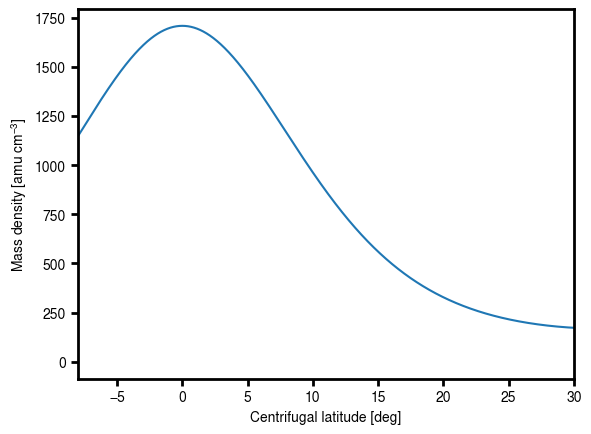

In [13]:
# プロット
fig, ax = plt.subplots()
ax.set_xlabel('Centrifugal latitude [deg]')
ax.set_ylabel('Mass density [amu cm$^{-3}$]')
ax.set_xlim(-8,30)
# ax.set_xscale('log')
ax.plot(90-np.degrees(theta_arr), rho_arr)
plt.show()

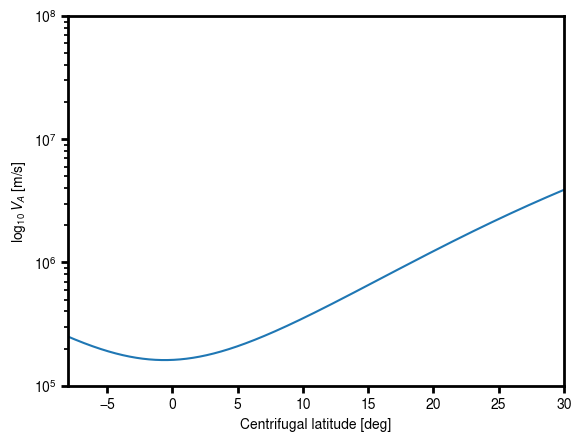

In [14]:
# プロット
fig, ax = plt.subplots()
ax.set_xlabel('Centrifugal latitude [deg]')
ax.set_ylabel(r'$\log_{10} V_A$ [m/s]')
ax.set_xlim(-8,30)
ax.set_ylim(1E+5,1E+8)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(90-np.degrees(theta_arr), Va_arr)
plt.show()

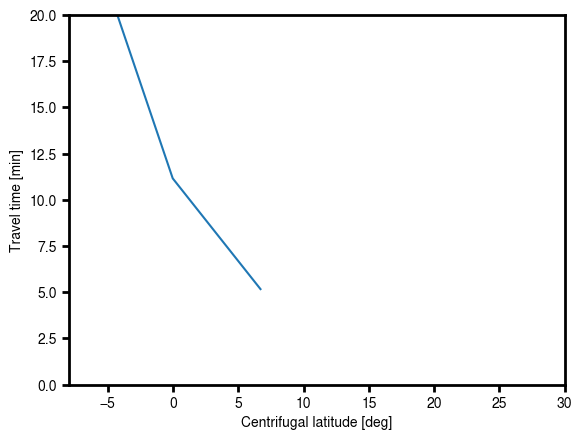

In [15]:
# プロット
fig, ax = plt.subplots()
ax.set_xlabel('Centrifugal latitude [deg]')
ax.set_ylabel(r'Travel time [min]')
ax.set_xlim(-8,30)
ax.set_ylim(0,20)
# ax.set_xscale('log')
ax.plot(Clat, tau_arr/60)
plt.show()

In [16]:
# np.savetxt('data/Traveltime/2022/tau_arr.txt', tau_arr)
# np.savetxt('data/Traveltime/2022/Va_arr.txt', Va_arr)
# np.savetxt('data/Traveltime/2022/rho_arr.txt', rho_arr)

# Appendix用Figure

In [17]:
idx0 = np.argmin(np.abs(90-np.degrees(theta_arr)-Clat[0]))
idx1 = np.argmin(np.abs(90-np.degrees(theta_arr)-Clat[1]))
idx2 = np.argmin(np.abs(90-np.degrees(theta_arr)-Clat[2]))

In [18]:
year = ['2014', '2022']

v 636.4021425001195 [amu cm-3]
s 1206.984640193568 [amu cm-3]
^ 649.3211483990895 [amu cm-3]
v 1283.7130812345079 [amu cm-3]
s 1707.9903026625038 [amu cm-3]
^ 1295.2749292664798 [amu cm-3]
v 13.938902254797739 [RJ]
s 11.265875902198847 [RJ]
^ 10.232893190846529 [RJ]


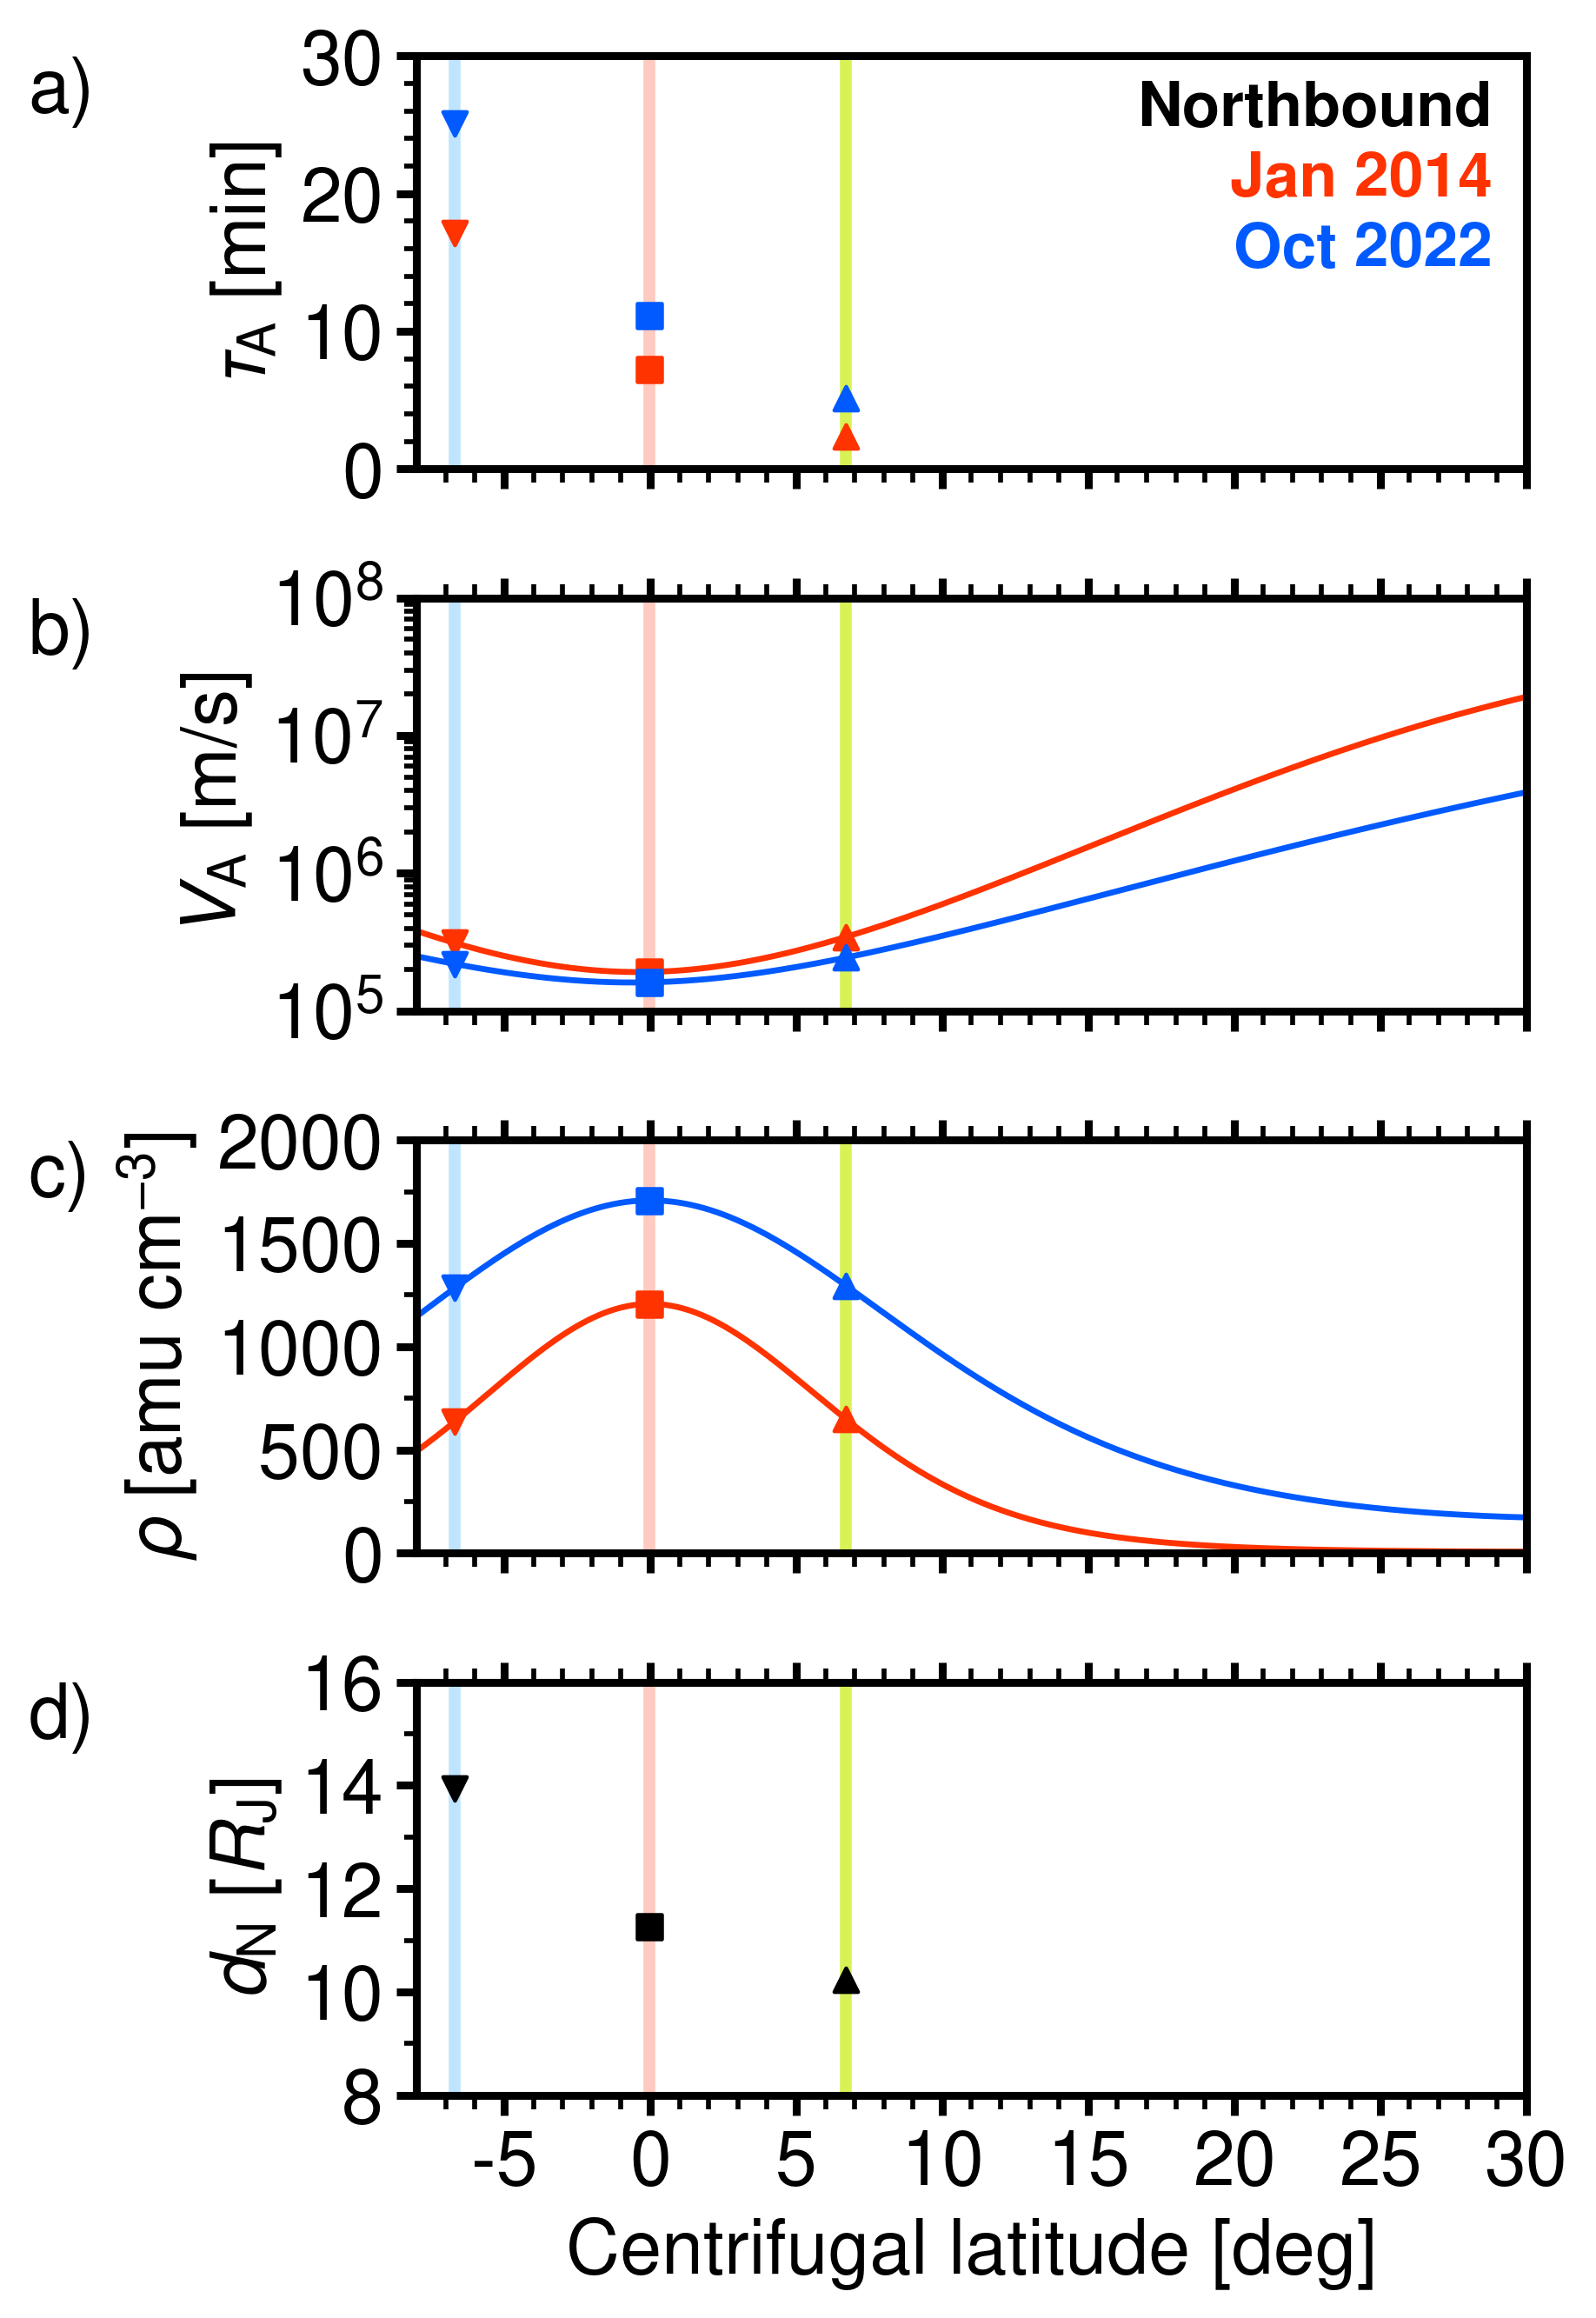

In [33]:
fsize = 19
fig, ax = plt.subplots(4, 1, figsize=(4.7, 7.8), dpi=326,
                       height_ratios=[1, 1, 1, 1])
# plt.subplots_adjust(left=0.2, top=0.95)
fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']

for i in range(ax.size):
    ax[i].set_xlim(-8, 30)
    ax[i].tick_params(axis='y', labelsize=fsize)
    ax[i].set_xticks(np.arange(-5, 31, 5))
    ax[i].set_xticklabels(np.arange(-5, 31, 5), fontsize=fsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(-5, 31, 5))
        ax2.set_xticklabels(np.arange(-5, 31, 5), fontsize=fsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fsize)

ax[i].set_xlabel('Centrifugal latitude [deg]', fontsize=fsize)


# Panel (a)
ax[0].set_ylabel(r'$\tau_{\rm A}$ [min]', fontsize=fsize)
ax[0].set_xlim(-8,30)
ax[0].set_ylim(0,30)
ax[0].set_yticks(np.array([0, 10, 20, 30]))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks

for i in range(2):
    tau_arr = np.loadtxt('data/Traveltime/'+str(year[i])+'/tau_arr.txt')
    ax[0].scatter(Clat[0], tau_arr[0]/60, marker='v', c=cud4[3*i], label='Southernmost', zorder=1)
    ax[0].scatter(Clat[1], tau_arr[1]/60, marker='s', c=cud4[3*i], label='Center', zorder=1)
    ax[0].scatter(Clat[2], tau_arr[2]/60, marker='^', c=cud4[3*i], label='Center', zorder=1)
ax[0].text(0.97, 0.94,
           'Northbound',
           color='k',
           weight='bold',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.83)
ax[0].text(0.97, 0.77,
           'Jan 2014',
           color=cud4[0],
           weight='bold',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.83)
ax[0].text(0.97, 0.60,
           'Oct 2022',
           color=cud4[3],
           weight='bold',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fsize*0.83)


# (b)
ax[1].set_ylabel(r'$V_{\rm A}$ [m/s]', fontsize=fsize)
ax[1].set_xlim(-8,30)
ax[1].set_ylim(1E+5,1E+8)
ax[1].set_yscale('log')
ax[1].set_yticks(np.array([1E+5, 1E+6, 1E+7, 1E+8]))
ax[1].yaxis.set_minor_locator(ptick.LogLocator(numticks=999, subs='auto'))  # minor ticks
for i in range(2):
    Va_arr = np.loadtxt('data/Traveltime/'+str(year[i])+'/Va_arr.txt')
    ax[1].plot(90-np.degrees(theta_arr), Va_arr, color=cud4[3*i], zorder=1)
    ax[1].scatter(90-np.degrees(theta_arr[idx0]), Va_arr[idx0], marker='v', c=cud4[3*i], zorder=1)
    ax[1].scatter(90-np.degrees(theta_arr[idx1]), Va_arr[idx1], marker='s', c=cud4[3*i], zorder=1)
    ax[1].scatter(90-np.degrees(theta_arr[idx2]), Va_arr[idx2], marker='^', c=cud4[3*i], zorder=1)


# (c)
ax[2].set_ylabel(r'$\rho$ [amu cm$^{-3}$]', fontsize=fsize)
ax[2].set_xlim(-8,30)
ax[2].set_ylim(0,2000)
ax[2].set_yticks(np.array([0, 500, 1000, 1500, 2000]))
ax[2].yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
for i in range(2):
    rho_arr = np.loadtxt('data/Traveltime/'+str(year[i])+'/rho_arr.txt')
    ax[2].plot(90-np.degrees(theta_arr), rho_arr, color=cud4[3*i], zorder=1)
    ax[2].scatter(90-np.degrees(theta_arr[idx0]), rho_arr[idx0], marker='v', c=cud4[3*i], zorder=1)
    ax[2].scatter(90-np.degrees(theta_arr[idx1]), rho_arr[idx1], marker='s', c=cud4[3*i], zorder=1)
    ax[2].scatter(90-np.degrees(theta_arr[idx2]), rho_arr[idx2], marker='^', c=cud4[3*i], zorder=1)
    print('v', rho_arr[idx0], '[amu cm-3]')
    print('s', rho_arr[idx1], '[amu cm-3]')
    print('^', rho_arr[idx2], '[amu cm-3]')


# (d)
ax[3].set_ylabel(r'$d_{\rm N}$ [$R_{\rm J}$]', fontsize=fsize)
ax[3].set_xlim(-8,30)
ax[3].set_ylim(8,16)
ax[3].set_yticks(np.array([8, 10, 12, 14, 16]))
ax[3].yaxis.set_minor_locator(AutoMinorLocator(2))  # minor ticks
ax[3].scatter(Clat[0], sf_arr[0]/RJ, marker='v', c='k', label='Southernmost', zorder=1)
ax[3].scatter(Clat[1], sf_arr[1]/RJ, marker='s', c='k', label='Center', zorder=1)
ax[3].scatter(Clat[2], sf_arr[2]/RJ, marker='^', c='k', label='Center', zorder=1)
print('v', sf_arr[0]/RJ, '[RJ]')
print('s', sf_arr[1]/RJ, '[RJ]')
print('^', sf_arr[2]/RJ, '[RJ]')


for j in range(ax.size):
    ax[j].axvline(Clat[0], color=cud4bs[3], linewidth=3, zorder=0.5)
    ax[j].axvline(Clat[1], color=cud4bs[0], linewidth=3, zorder=0.5)
    ax[j].axvline(Clat[2], color=cud4bs[2], linewidth=3, zorder=0.5)